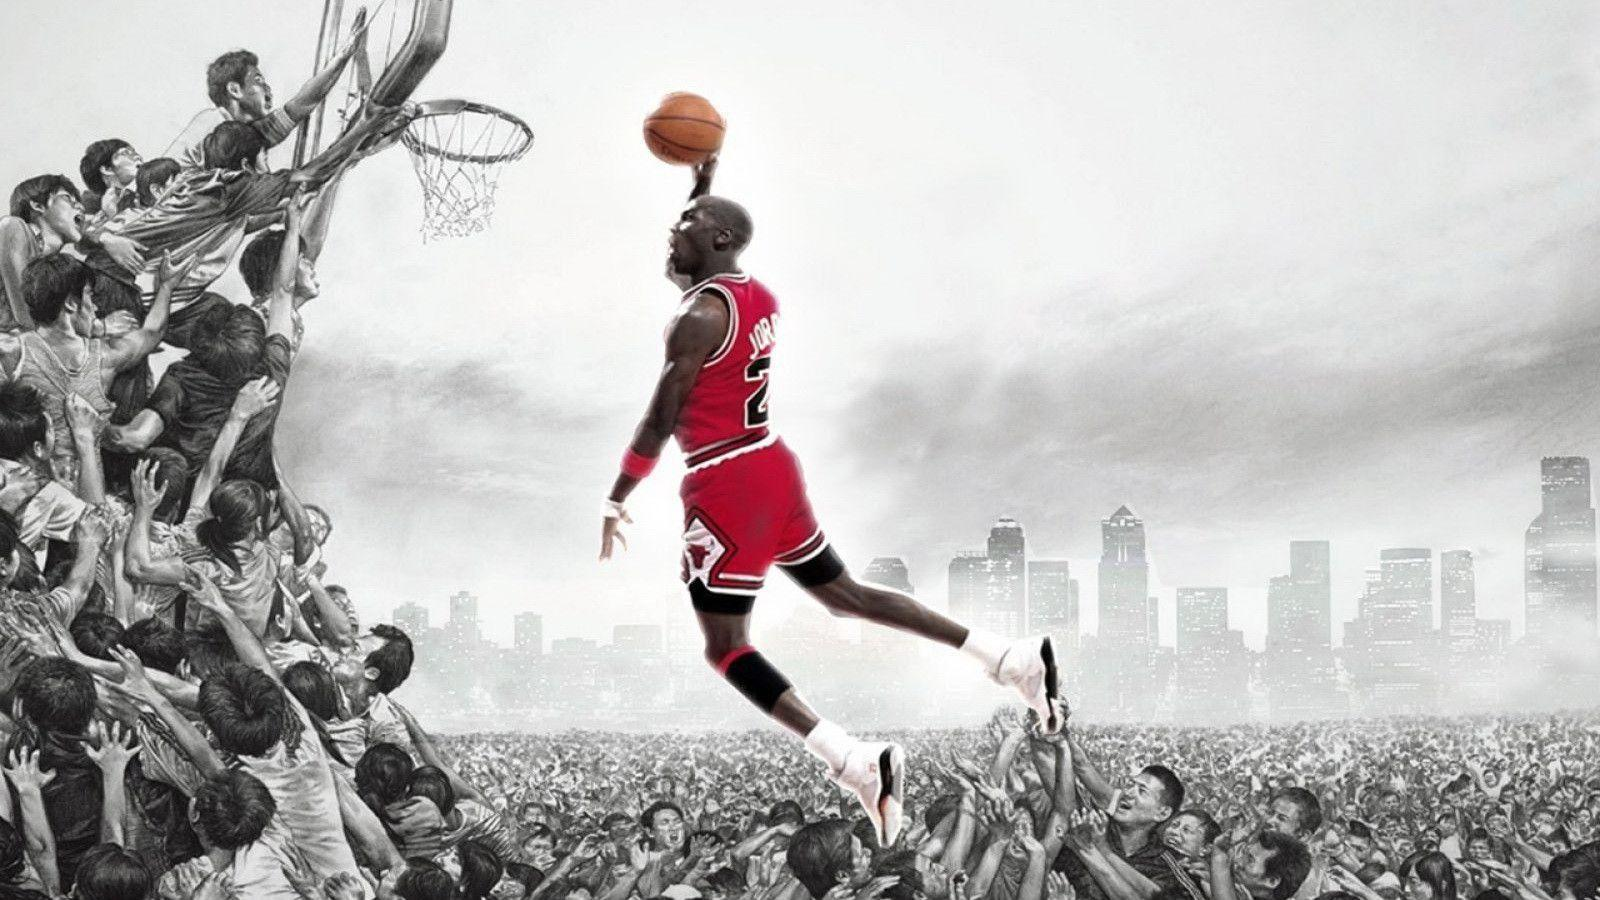

# An Analysis on the Influence of NBA Player Statistics on Injury Occurrence
#### By André Gadelha, Gabriel das Neves, Lucas Ferreira e Felipe Cunha 
The NBA moves billions of dollars per year. The league concentrates the best players in the world, capable of incredible plays and exciting games. But when it comes to money, everything becomes just numbers. Models that predict future player performance are worth millions, algorithms that can precisely measure how much each player is worth promote great savings for teams. So, in this work I seek to analyze player data to obtain answers to some points:

1. What are the most relevant statistics to determine possible injuries?
2. Develop a way to predict if a player will have an injury?
3. How do physical characteristics influence the possibility of injuries?

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import numpy as np

### Injuries Dataset
This dataset contains all injuries that occurred in recent years. We defined that we want to determine if a player gets injured or not according to their statistics, so the number of injuries in the year was discarded.

In [9]:
df1 = pd.read_csv('/content/injuries.csv')
df1['Date'] = pd.to_datetime(df1['Date'])
df1['Ano'] = [i.year for i in df1['Date']]
df1.drop('Acquired', axis = 1, inplace = True)
df1.dropna(inplace = True)
df1.drop(['Date', 'Team', 'Notes'], axis = 1, inplace = True)
df1['Lesionado'] = 1
df1.columns = ['Player', 'Ano', 'Lesionado']
df1['Ano']+=1
df1 = df1.groupby(['Player','Ano']).count()

df1

Lesionado
Player             Ano            
 Mike Scott        2014          1
                   2015          2
                   2016          4
                   2017          3
                   2019          2
...                            ...
Zion Williamson    2020          3
                   2021          3
Zoran Dragic       2015          8
                   2016          5
Zydrunas Ilgauskas 2012          3

[4427 rows x 1 columns]

### Player Speed Dataset
This dataset contains all characteristics of distance traveled and playing time

In [10]:
df2 = pd.read_csv('/content/speed13-20.csv')
df2.columns = ['Player', 'TEAM', 'GP', 'W', 'L', 'MIN', 'DIST. FEET', 'DIST. MILES',
       'DIST. MILES OFF', 'DIST. MILES DEF', 'AVG SPEED', 'AVG SPEED OFF',
       'AVG SPEED DEF', 'Ano']

df2.head()

,Player,TEAM,GP,W,L,MIN,DIST. FEET,DIST. MILES,DIST. MILES OFF,DIST. MILES DEF,AVG SPEED,AVG SPEED OFF,AVG SPEED DEF,Ano
0,Zaza Pachulia,MIL,52,10,42,1310,453514,85.9,44.0,41.9,3.94,4.01,3.86,2013
1,Zach Randolph,MEM,79,49,30,2705,922134,174.6,92.2,82.4,3.88,3.90,3.85,2013
2,Xavier Henry,LAL,43,16,27,908,357114,67.6,35.0,32.7,4.49,4.82,4.20,2013
3,Wilson Chandler,DEN,62,27,35,1927,717124,135.8,71.2,64.6,4.24,4.62,3.90,2013
4,Willie Green,LAC,55,38,17,869,329326,62.4,32.3,30.1,4.32,4.58,4.06,2013


### Physical Characteristics Dataset
This dataset contains the physical characteristics of the players

In [11]:
df3 = pd.read_csv('/content/bios.csv')
df3.drop(['TEAM','COLLEGE','COUNTRY','DRAFT YEAR','DRAFT NUMBER',
          'DRAFT ROUND','GP','PTS','OREB%','USG%','TS%','AST%','DREB%'], inplace = True, axis=1)

df3.head()

,PLAYER,AGE,HEIGHT,WEIGHT,REB,AST,NETRTG,Ano
0,AJ Price,27,6/2,195,10,13,0.9,2013
1,Aaron Brooks,29,6/1,161,140,233,-2.6,2013
2,Aaron Gray,29,7/1,270,111,22,-11.1,2013
3,Adonis Thomas,21,6/7,240,3,3,17.2,2013
4,Al Harrington,34,6/9,245,80,28,4.7,2013


In [ ]:
#Converting heights to centimeters
alturas = []
for altura in df3['HEIGHT']:
    if altura == '-':
        altura = sum(alturas)/len(alturas)
        alturas.append(altura)
        continue
    altura = altura.replace('/',' ').split()
    alturas.append(round((float(altura[0])*30.48 + float(altura[1])*2.54),0))
alturas = pd.DataFrame(alturas)
alturas.columns=['Altura']
alturas.index=df3.index
df3['Altura'] = alturas

#Transformando pesos para kilograma
weights = []
for weight in df3['WEIGHT']:
    if weight == '-':
        weight = sum(weights)/len(weights)
        weights.append(weight*0.45)
        continue
    weights.append(float(weight)*0.45)
weights = pd.DataFrame(weights)
weights.columns=['Peso']
weights.index=df3.index
df3['Peso'] = weights
df3.drop(['HEIGHT','WEIGHT'],inplace = True, axis=1)

#Formatando o Dataset
df3.columns = ['Player', 'AGE', 'REB', 'AST', 'NETRTG', 'Ano', 'Altura', 'Peso']
df3['REB'] = pd.to_numeric(df3['REB'], errors = 'coerce')



### Combining the Datasets
Here we will combine the datasets in order to use only one dataset.

In [13]:
data = pd.merge(df2,df1,how = 'left', on = ['Player','Ano'])
data = pd.merge(data,df3,how = 'left', on = ['Player','Ano'])
data['Lesionado'].fillna(0,inplace = True)
data['Lesão'] = [1 if i>0 else 0 for i in data['Lesionado']]
data.head()

,Player,TEAM,GP,W,L,MIN,DIST. FEET,DIST. MILES,DIST. MILES OFF,DIST. MILES DEF,AVG SPEED,AVG SPEED OFF,AVG SPEED DEF,Ano,Lesionado,AGE,REB,AST,NETRTG,Altura,Peso,Lesão
0,Zaza Pachulia,MIL,52,10,42,1310,453514,85.9,44.0,41.9,3.94,4.01,3.86,2013,2.0,30.0,333.0,136.0,-6.4,211.0,123.75,1
1,Zach Randolph,MEM,79,49,30,2705,922134,174.6,92.2,82.4,3.88,3.90,3.85,2013,2.0,32.0,795.0,200.0,3.0,206.0,117.00,1
2,Xavier Henry,LAL,43,16,27,908,357114,67.6,35.0,32.7,4.49,4.82,4.20,2013,3.0,23.0,114.0,51.0,-2.3,198.0,99.00,1
3,Wilson Chandler,DEN,62,27,35,1927,717124,135.8,71.2,64.6,4.24,4.62,3.90,2013,10.0,27.0,294.0,114.0,-4.5,203.0,101.25,1
4,Willie Green,LAC,55,38,17,869,329326,62.4,32.3,30.1,4.32,4.58,4.06,2013,6.0,32.0,78.0,50.0,4.9,190.0,90.45,1


### Drop
Now we will remove the columns used to perform the merge and remove missing data.

In [14]:
data.drop('Lesionado', inplace= True, axis = 1)
data1 = data.drop(['Player', 'TEAM', 'W', 'L', 'DIST. MILES',
       'DIST. MILES OFF', 'DIST. MILES DEF', 'AVG SPEED OFF',
       'AVG SPEED DEF', 'Ano'], axis=1)
data1['DIST. FEET'] = pd.to_numeric(data1['DIST. FEET'], errors='coerce')
data1['DIST. FEET'].fillna(data1['DIST. FEET'].mean(), inplace = True)
data1.head()


,GP,MIN,DIST. FEET,AVG SPEED,AGE,REB,AST,NETRTG,Altura,Peso,Lesão
0,52,1310,453514.0,3.94,30.0,333.0,136.0,-6.4,211.0,123.75,1
1,79,2705,922134.0,3.88,32.0,795.0,200.0,3.0,206.0,117.00,1
2,43,908,357114.0,4.49,23.0,114.0,51.0,-2.3,198.0,99.00,1
3,62,1927,717124.0,4.24,27.0,294.0,114.0,-4.5,203.0,101.25,1
4,55,869,329326.0,4.32,32.0,78.0,50.0,4.9,190.0,90.45,1


Here we will consider players with more than 20 games and more than 550 minutes played to validate that the injuries were caused by the game.

In [15]:
data_n = data1[data1['GP']>20]

In [16]:
data_n = data1[data1['MIN']>550]

## Analyzing the Data
As a way to identify patterns within the data we use the correlation matrix.

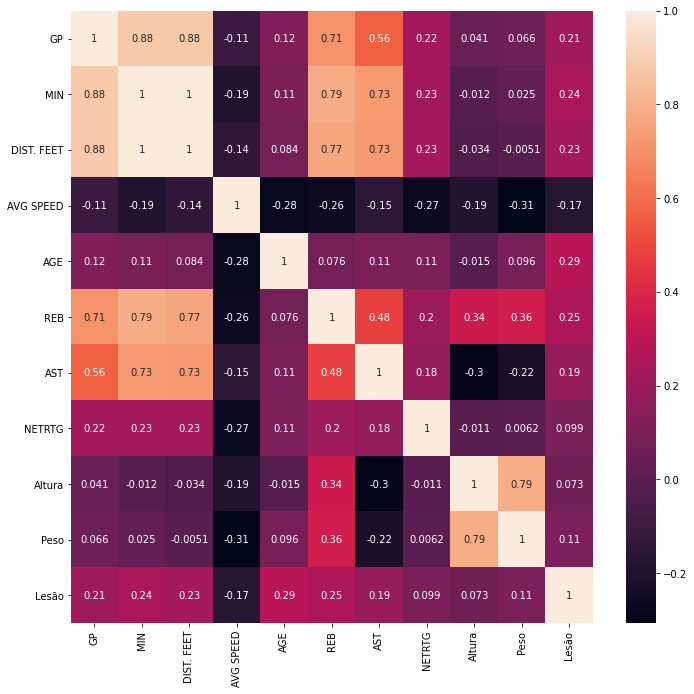

In [17]:
fig, ax = plt.subplots(figsize = (11.7, 11.27))
px.scatter_matrix(data1,
    dimensions=["GP", "MIN", "DIST. FEET", "AVG SPEED","AGE","REB","AST","NETRTG","Altura","Peso","Lesão"],
    color="Lesão")
sns.heatmap(ax = ax, data=data1.corr(), annot=True)


### Matriz de correlação
Na matriz de correlação O sinal do coeficiente de 
correlação tem como função apenas indicar se as duas variáveis se correlacionam de maneira diretamente proporcional ou inversamente proporcional. Como maior valor com a coluna lesão a coluna Idade, o que era de se esperar. Além disso os valores que chamaram atenção foram: Distância (DIST. FEET), Numero de rebotes (REB), Minutos de jogo (MIN)e quantidade de jogos jogados (GP). Essas features nos dão uma pista de valores que podem estar relacionados às lesões.

### Approach by Class
We separated the datasets by class to visualize if we have separable data or not between the classes. Several scatter analyses were performed to determine a possible data separation.

In [18]:
lesionados = data_n[data_n['Lesão']==1]
n_lesionados = data_n[data_n['Lesão']==0]


In [19]:
lesionados.describe()

,GP,MIN,DIST. FEET,AVG SPEED,AGE,REB,AST,NETRTG,Altura,Peso,Lesão
count,1795.000000,1795.000000,1.795000e+03,1795.000000,1795.000000,1787.000000,1795.000000,1795.000000,1795.000000,1795.000000,1795.0
mean,63.391643,1607.392201,6.042892e+05,4.201175,27.746518,297.759373,161.256267,0.227967,200.870752,99.546017,1.0
std,13.715652,608.698219,2.229222e+05,0.209161,4.064123,175.575819,133.722053,5.705876,8.909867,11.542394,0.0
min,18.000000,551.000000,1.963250e+05,3.530000,20.000000,31.000000,8.000000,-18.200000,175.000000,72.450000,1.0
25%,55.000000,1091.000000,4.164755e+05,4.070000,25.000000,166.000000,69.500000,-3.700000,193.000000,90.000000,1.0
50%,66.000000,1601.000000,6.037190e+05,4.210000,27.000000,255.000000,116.000000,0.400000,201.000000,99.000000,1.0
75%,75.000000,2071.500000,7.743255e+05,4.340000,30.000000,391.500000,212.000000,4.000000,208.000000,108.000000,1.0
max,83.000000,3125.000000,1.175886e+06,4.880000,42.000000,963.000000,840.000000,20.100000,221.000000,132.750000,1.0


In [20]:
n_lesionados.describe()

,GP,MIN,DIST. FEET,AVG SPEED,AGE,REB,AST,NETRTG,Altura,Peso,Lesão
count,954.000000,954.000000,9.540000e+02,954.000000,954.000000,945.000000,954.000000,954.000000,954.000000,954.000000,954.0
mean,64.141509,1500.267296,5.754681e+05,4.286876,25.530398,248.047619,138.467505,-1.304612,199.794549,97.549528,0.0
std,13.768583,619.378098,2.305098e+05,0.190621,4.152348,148.033382,120.966246,5.649379,8.928169,10.844427,0.0
min,19.000000,553.000000,1.883510e+05,3.640000,19.000000,36.000000,6.000000,-18.300000,175.000000,67.500000,0.0
25%,55.000000,983.250000,3.812295e+05,4.170000,22.000000,143.000000,59.000000,-5.100000,193.000000,90.000000,0.0
50%,67.000000,1428.000000,5.532325e+05,4.300000,25.000000,216.000000,98.500000,-1.200000,201.000000,96.750000,0.0
75%,75.750000,1978.500000,7.650885e+05,4.420000,28.000000,311.000000,185.750000,2.400000,206.000000,105.750000,0.0
max,83.000000,3122.000000,1.153367e+06,4.850000,43.000000,954.000000,907.000000,18.000000,221.000000,127.800000,0.0


In the General approach we see clear differences in the classes, non-injured players have less playing time, fewer games played, fewer rebounds, fewer assists, are younger, have lower and more variable performance than injured players. Characteristics such as height, weight and speed do not seem to influence. This strengthens our assumptions taken from the correlation matrix. We will work with these features for prediction.

Still, adopting only these features did not contribute to an acceptable accuracy. Therefore, for empirical reasons, we will approach all features.

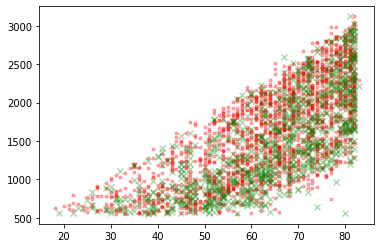

In [21]:
plt.scatter(lesionados['GP'],lesionados['MIN'], c= 'r', marker = '.',alpha=0.3);
plt.scatter(n_lesionados['GP'],n_lesionados['MIN'], c= 'g', marker = 'x',alpha=0.3);

In this scatter it is possible to see an apparent possible data separation, perhaps an algorithm with non-linear kernels can handle this separability.

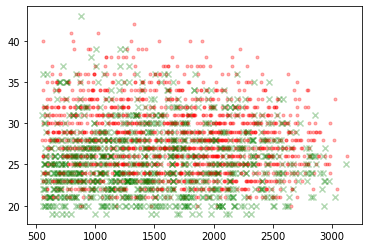

In [22]:
plt.scatter(lesionados['MIN'],lesionados['AGE'], c= 'r', marker = '.',alpha=0.3);
plt.scatter(n_lesionados['MIN'],n_lesionados['AGE'], c= 'g', marker = 'x',alpha=0.3);

Esse plot apresenta a mesma caracteristica.

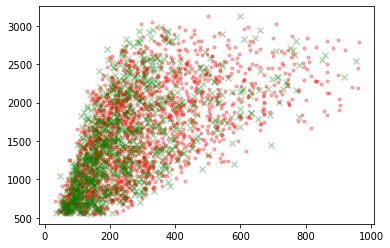

In [23]:
plt.scatter(lesionados['REB'],lesionados['MIN'], c= 'r', marker = '.',alpha=0.3);
plt.scatter(n_lesionados['REB'],n_lesionados['MIN'], c= 'g', marker = 'x',alpha=0.3);

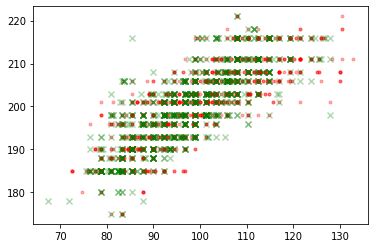

In [24]:
plt.scatter(lesionados['Peso'],lesionados['Altura'], c= 'r', marker = '.',alpha=0.3);
plt.scatter(n_lesionados['Peso'],n_lesionados['Altura'], c= 'g', marker = 'x',alpha=0.3);

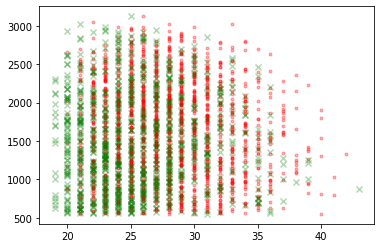

In [25]:
plt.scatter(lesionados['AGE'],lesionados['MIN'], c= 'r', marker = '.',alpha=0.3);
plt.scatter(n_lesionados['AGE'],n_lesionados['MIN'], c= 'g', marker = 'x',alpha=0.3);

Let's check how the distributions of our features are

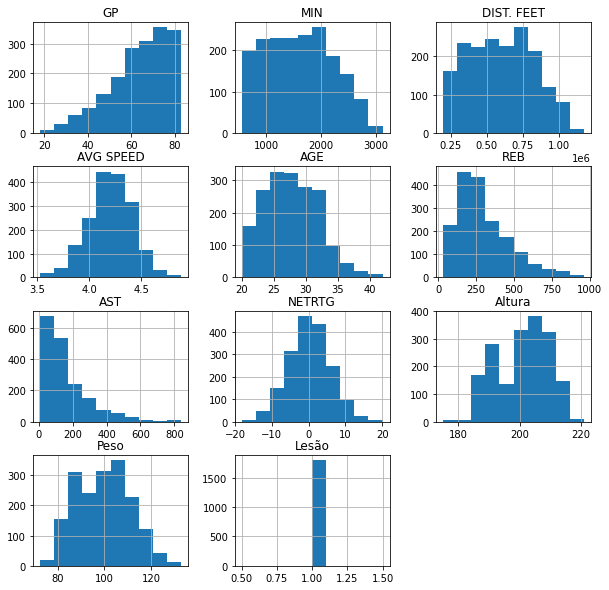

In [26]:
lesionados.hist(figsize=(10,10));

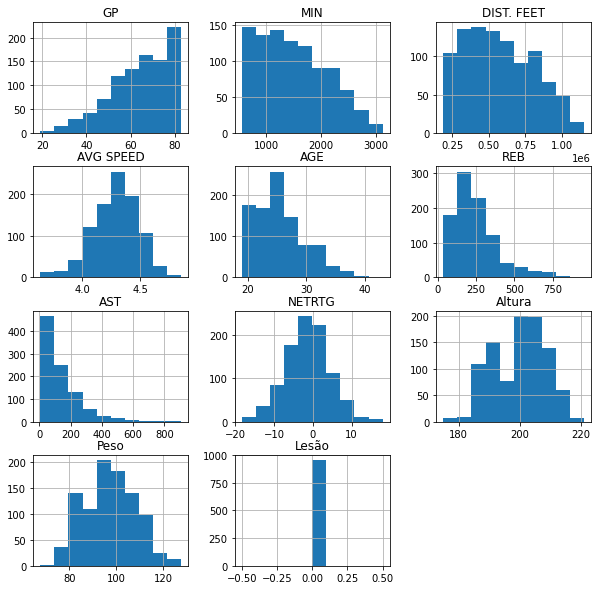

In [27]:
n_lesionados.hist(figsize=(10,10));

Let's check the skewness of our data to decide if it will be necessary to use methods to reduce these values such as BOX & COX.

In [28]:

print(scipy.stats.skew(lesionados.GP))
print(scipy.stats.skew(lesionados.MIN))
print(scipy.stats.skew(lesionados["DIST. FEET"]))
print(scipy.stats.skew(lesionados.REB, nan_policy= 'omit'))


-0.73688314593315
0.14586408798786837
0.10690374479149695
1.1394563902402803


The skewness values remained close to zero. This tells us that the data is symmetric.

The next step is the development of the models.

## Models

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectPercentile,f_regression
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression,SGDClassifier
import sklearn.metrics as metrics
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier

Train and test split

In [30]:
y = data_n[['Lesão']]
x = data_n.drop('Lesão',axis=1)
x = x.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=2)
#checando:
X_train

,GP,MIN,DIST. FEET,AVG SPEED,AGE,REB,AST,NETRTG,Altura,Peso
50,76,1948,700952.0,4.10,34.0,234.0,119.0,1.5,206.0,96.75
175,81,2153,716573.0,3.80,24.0,485.0,144.0,3.4,208.0,110.25
2994,43,1133,454766.0,4.24,27.0,148.0,46.0,0.3,198.0,95.40
1171,76,2804,989967.0,4.02,30.0,365.0,494.0,6.4,185.0,92.25
1091,66,1313,490994.0,4.27,23.0,174.0,38.0,-5.9,198.0,103.50
...,...,...,...,...,...,...,...,...,...,...
3717,56,1499,587164.0,4.23,31.0,519.0,202.0,-4.9,211.0,114.30
3449,57,1420,551063.0,4.12,32.0,122.0,262.0,1.5,180.0,82.35
2311,65,1615,613781.0,4.35,32.0,152.0,124.0,-7.4,198.0,87.75
3759,54,904,377260.0,4.47,20.0,71.0,124.0,0.8,185.0,76.50


## KNN


K-Nearest Neighbors (KNN) is a very simple machine learning algorithm, easy to understand, versatile and one of the most advanced.

"The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point and predict the label from them. The number of samples can be a user-defined constant (k-nearest neighbor learning), or vary based on the local density of points (radius-based neighbor learning)."

In [31]:
n_neighbors =10
clf = KNeighborsClassifier(n_neighbors=n_neighbors)
clf.fit(X_train,y_train.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [32]:
y_pred = clf.predict(X_test)
print(y_pred)
clf.score(X_test, y_test)

[0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0
 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 1
 1 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 0
 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0
 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 0
 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1
 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1
 1 1 0 1 1 1 0 0 1 1 1 1 

0.5857558139534884

In [33]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.38      0.27      0.31       244
           1       0.65      0.76      0.70       444

    accuracy                           0.59       688
   macro avg       0.52      0.51      0.51       688
weighted avg       0.56      0.59      0.57       688



## SVM

The goal of this algorithm is to find the best hyperplane that divides the data into two groups.

"Support vectors" are simply the coordinates of the individual under observation. Support Vector Machine is a boundary that best segregates the two classes (hyperplane / line).


In [34]:

clf2 = svm.SVC() # definindo o classificador, aqui podemos escolher se vai usar uma abordagem linear
 # ou polinomial, etc pelo parâmetro do kernel
 # ex: svm.SVC(kernel='poly')
clf2.fit(X_train,y_train.values.ravel()) # treinando o classificador

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [35]:
clf2.predict(X_test) #testando

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [36]:
clf2.score(X_test, y_test) # conferindo a acurácia

0.6453488372093024

## Decision Tree

From the choice of the root node, the decision tree decides by dividing into nodes. The division is based on metrics by their metrics.

Despite being algorithms unstable to changes in data, decision trees are simple to understand and implement.

In contrast to linear models, they map non-linear relationships very well, which would be our case since we will use all features, not only those from the correlation matrix, but also those with little linear relationships as shown in the Approach by Class section in the scatter-plots.

In [37]:
pipe_tree = make_pipeline(MinMaxScaler(),
                        SelectPercentile(f_regression, percentile=70),
                        PolynomialFeatures(2),
                        tree.DecisionTreeClassifier())
pipe_tree.fit(X_train, y_train)
y_pred = pipe_tree.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

0.6191860465116279
              precision    recall  f1-score   support

           0       0.46      0.42      0.44       244
           1       0.70      0.73      0.71       444

    accuracy                           0.62       688
   macro avg       0.58      0.57      0.57       688
weighted avg       0.61      0.62      0.61       688



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



## Logistic Regression

Classification algorithm based on the probability of class membership, that is, it predicts the probability of the categorical value of an input.

Showing results in the form of probabilities is an advantage in using this type of regression, in addition, logistic regression has a high degree of reliability.

In [38]:
pipe_lrc = make_pipeline(MinMaxScaler(),
                        SelectPercentile(f_regression, percentile=77),
                        PolynomialFeatures(2),
                        LogisticRegression(penalty='elasticnet',solver='saga',max_iter=20000,l1_ratio=0.2))
pipe_lrc.fit(X_train, y_train.values.ravel())
y_pred = pipe_lrc.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

0.7093023255813954
              precision    recall  f1-score   support

           0       0.68      0.34      0.45       244
           1       0.72      0.91      0.80       444

    accuracy                           0.71       688
   macro avg       0.70      0.63      0.63       688
weighted avg       0.70      0.71      0.68       688



In [65]:
X_test

,GP,MIN,DIST. FEET,AVG SPEED,AGE,REB,AST,NETRTG,Altura,Peso
660,70,1587,581340.0,4.17,37.0,211.0,293.0,9.8,198.0,92.25
3006,50,646,266857.0,4.35,22.0,67.0,87.0,7.0,185.0,83.25
1316,72,2125,857837.0,4.60,22.0,261.0,467.0,-1.4,193.0,83.25
2517,51,720,292927.0,4.32,19.0,145.0,80.0,-0.3,201.0,96.75
3421,65,1656,722203.0,4.68,23.0,383.0,271.0,-4.2,193.0,81.00
...,...,...,...,...,...,...,...,...,...,...
2317,79,2034,751515.0,4.21,29.0,244.0,173.0,-1.1,201.0,99.00
3058,46,1147,445678.0,4.15,22.0,331.0,83.0,-6.6,208.0,111.60
3398,69,2079,827671.0,4.24,27.0,405.0,114.0,6.5,201.0,99.00
1827,71,1860,678973.0,4.16,30.0,275.0,74.0,2.8,203.0,95.40


## Model Selection

Among the trained models and according to their accuracies for both injured and non-injured groups, the model that performed best was logistic regression with elasticnet penalty parameter, but we also obtained close results as in the Decision Tree model. Even so, given the high degree of reliability of logistic regression as well as the fact that it uses probabilities, we chose this as the model to be used.


## Case Test

Given the study presented above, we propose to perform a test in a real situation. Analyzing the case of player Luís Gruber, who suffered an injury in the second quarter of the game between Mogi and Quimsa in the Champions League, in January 2020. Upon obtaining all relevant information about Luis so that we can apply his data to the algorithm developed here, we have:

In [67]:
rebotes = 1075.0
jogos = 310
altura = 201
peso = 111
velMedia = 4.23
distPes = 596529.0
min = 7904.0
ast = 379
idade = 36
netrtg = 0.25

In [75]:
luis = [[jogos, min, distPes, velMedia, idade, rebotes, ast, netrtg, altura, peso]]
print(luis)
y_pred = pipe_lrc.predict(luis)
print(y_pred)

[[310, 7904.0, 596529.0, 4.23, 36, 1075.0, 379, 0.25, 201, 111]]
[1]


Como podemos ver, o algorítmo conseguiu prever perfeitamente a lesão do jogador.

## Conclusão

Throughout this work we focused on the NBA database, therefore not so comprehensive, to investigate the following points:

1. What are the most relevant statistics to determine possible injuries?
2. Develop a way to predict if a player will have an injury.
3. How do physical characteristics influence the possibility of injuries?

Based on the approaches of this project, the most relevant statistics for possible injuries are: Distance traveled, Number of rebounds, Minutes of play, age and number of games played.

Given the EDA strategies developed and discussed here, the way we developed to predict injuries was through the Logistic Regression algorithm, as discussed earlier.

Finally, Surprisingly, physical characteristics are not the ones that most influence injuries. We discussed this result and suspect that this is due to the fact that they are athletes with physical preparation to withstand their weights, that is, there is muscle preparation to withstand landing in a rebound, etc. 

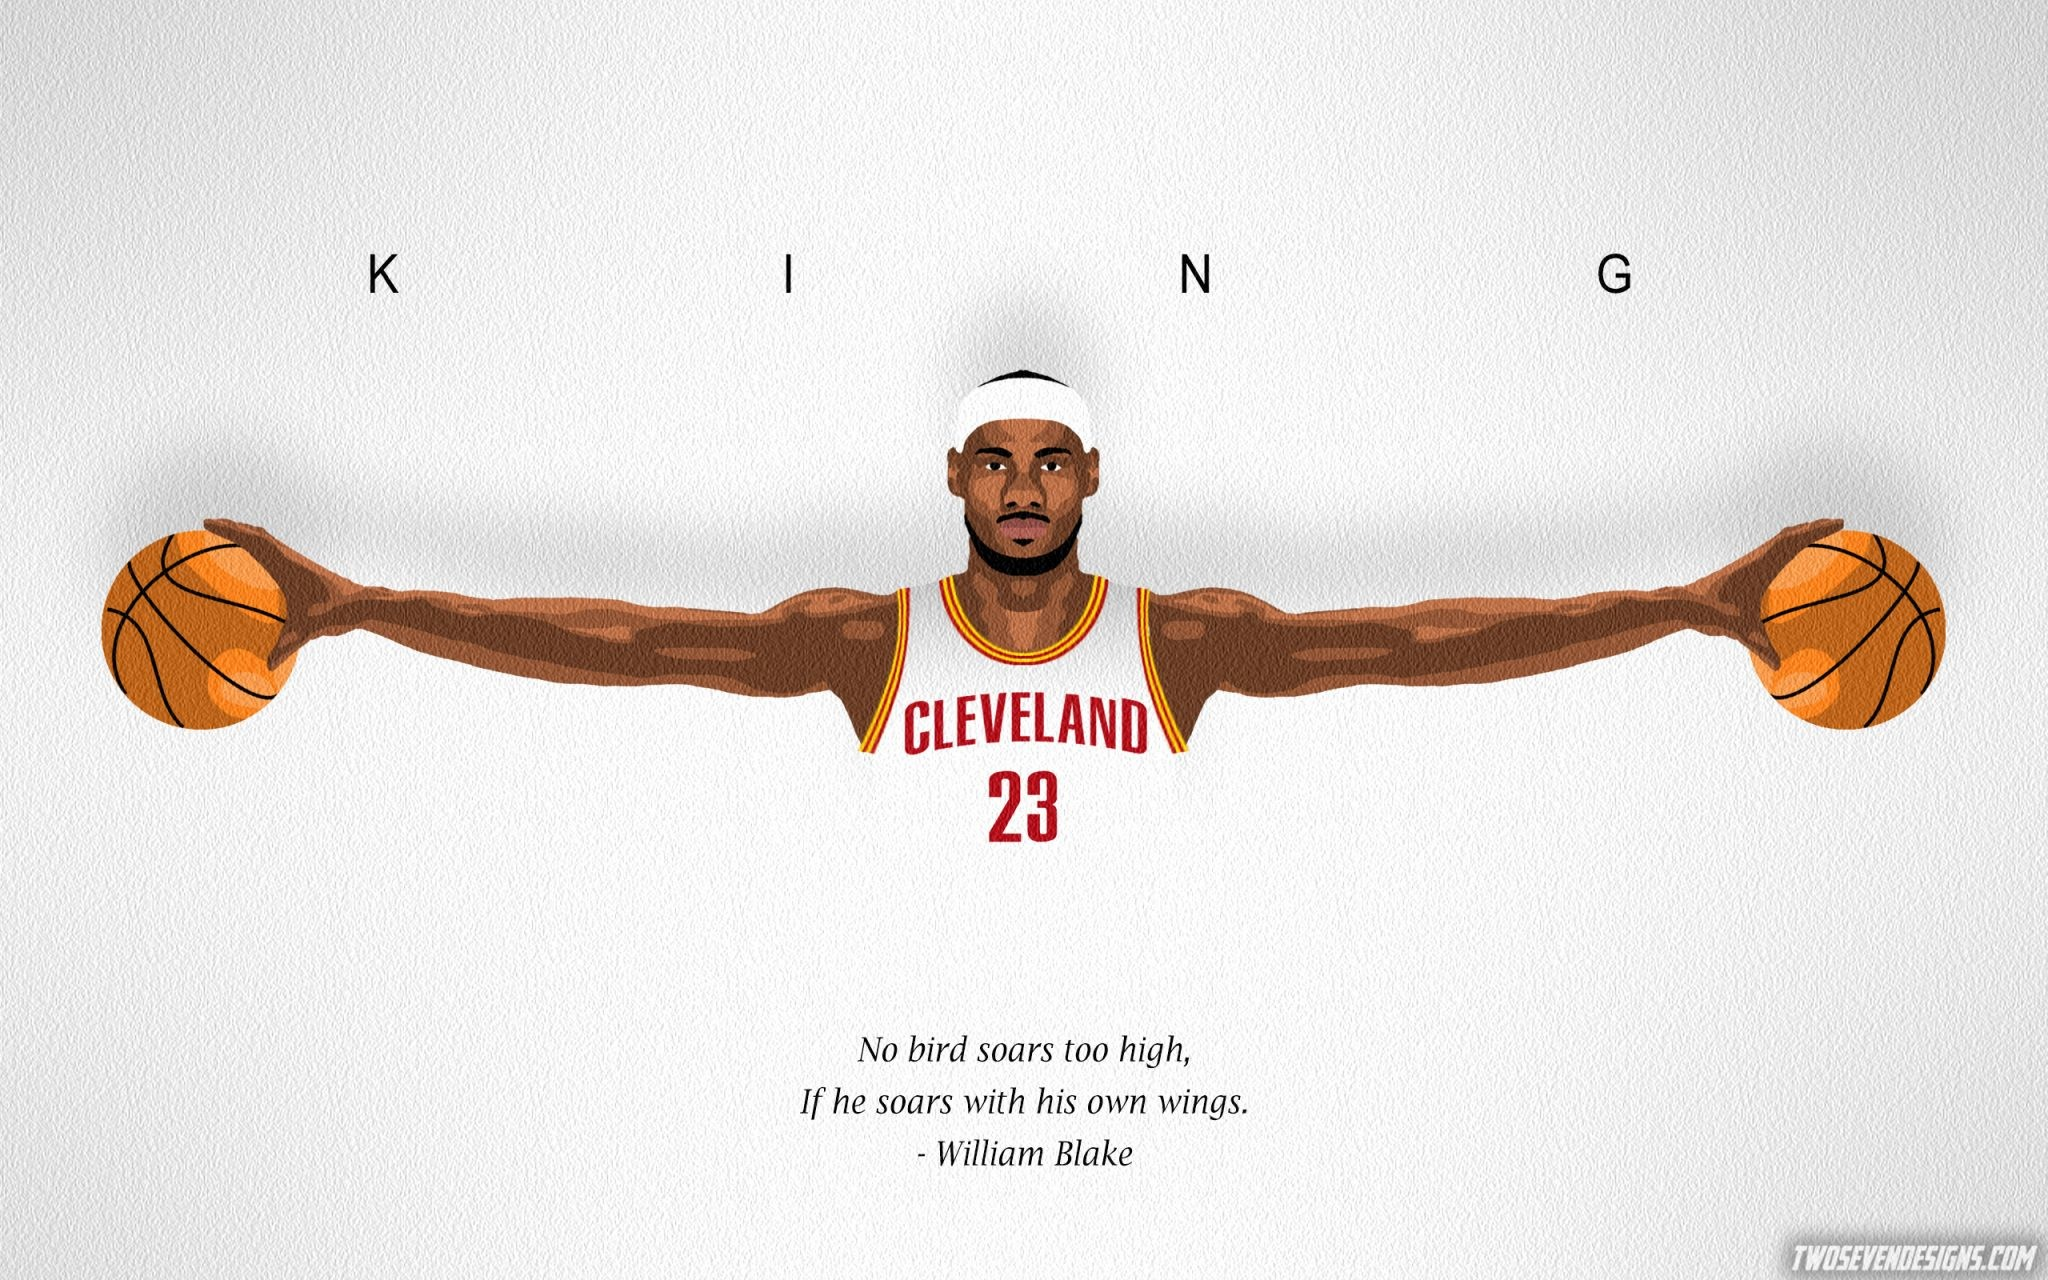